# Q2 - solução

#### O que é para fazer

Um código que plota **na tela** sobre a imagem o ponto de interseção entre as retas. 

#### Orientações

O código base para este exercício está em `q2/q2.py`. Este exercício **não precisa** de ROS

![](./figura_q2.png)

Embora cada aluno tivesse um par de interseções determinado, nós precisamos resolver para todas as interseções *possíveis*:

* Interseção R-G
* Interseção G-B
* Interseção B-R

**Rubrica:**




|Resultado| Conceito| 
|---|---|
| Não executa | 0 |
| Segmenta as retas mas não calcula interseção | 1.5 |
| Calcula interseção com falhas | 2.3 |
| Funciona perfeitamente | 3.3 | 

Casos intermediários ou omissos da rubrica serão decididos pelo professor.

## Resposta

A questão pode ser resolvida via `inRange`, mas torna-se *muito mais fácil* de resolver quando notamos que os valores das retas são praticamente as componentes R (vermelha), G (verde) e B (azul) puras.


Vamos começar realizando a análise sobre um *frame* para em seguida copiar o código para o arquivo *Python*:

In [1]:
def multiplot(imgs, legenda):
    """ Função que plota n imagens BGR em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        
def multiplot_gray(imgs, legenda):
    """ Função que plota n imagens grayscale em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0],  vmin=0, vmax=255, cmap="Greys_r"))
        return
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], vmin=0, vmax=255, cmap="Greys_r")

In [2]:
from __future__ import print_function, division

import cv2
import numpy as np
import imlib
import os
import os.path
import matplotlib.pyplot as plt
import math

%matplotlib inline

print("Versao da Cv2 ", cv2.__version__)
import sys
print("Versao do Python", sys.version)

Versao da Cv2  4.1.1
Versao do Python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


### Visualizando os canais R, G e B

In [3]:
frame_bgr = cv2.imread("lines.png")
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

R = frame[:,:,0]
G = frame[:,:,1]
B = frame[:,:, 2]

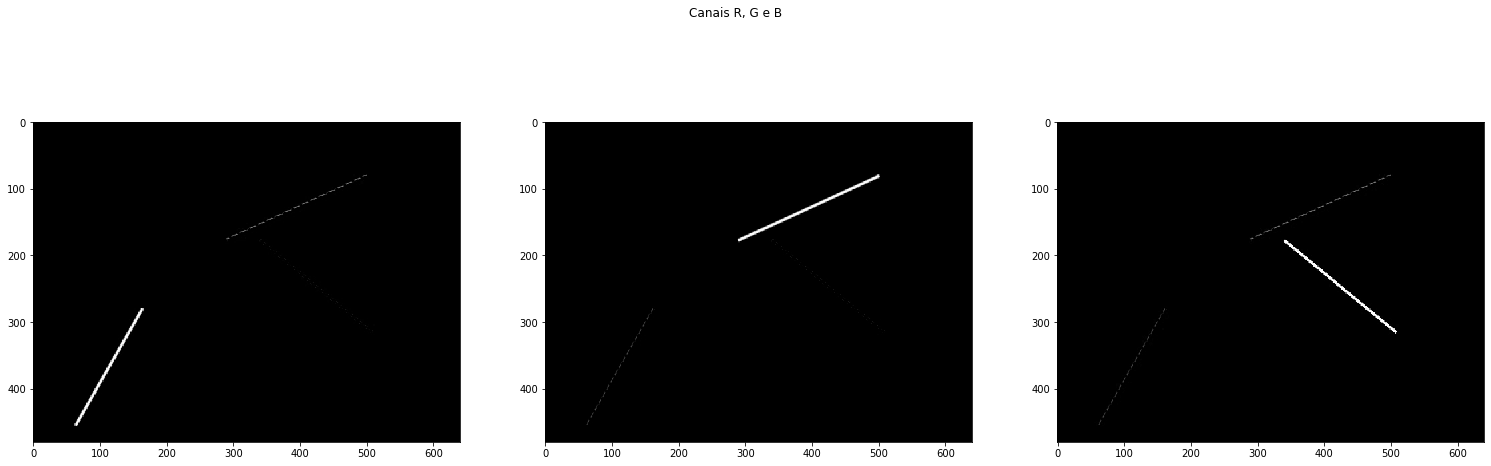

In [4]:
multiplot_gray([R, G, B], "Canais R, G e B")

Apesar de o contraste estar muito bom, ainda não é perfeito. Notam-se alguns traçoes em cinza. Vamos recorrer à função cv2. threshold que foi vista na aula 2.

In [5]:
ret, R2 = cv2.threshold(R, 200, 255, cv2.THRESH_OTSU)

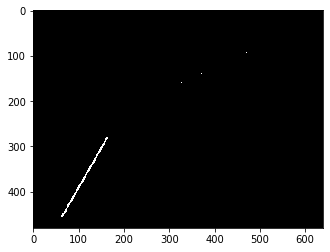

In [6]:
plt.imshow(R2, cmap="Greys_r", vmin=0, vmax=255)

In [7]:
ret, G2 = cv2.threshold(G, 200, 255, cv2.THRESH_OTSU)

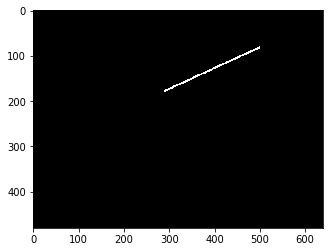

In [8]:
plt.imshow(G2, cmap="Greys_r", vmin=0, vmax=255)

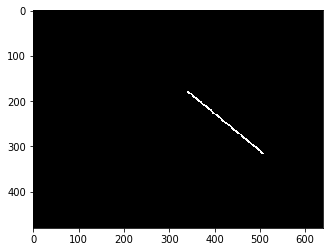

In [9]:
ret, B2 = cv2.threshold(B, 250, 255, cv2.THRESH_OTSU)
plt.imshow(B2, cmap="Greys_r", vmin=0, vmax=255)

### Aplicando HoughLines

In [10]:
filtradas_rgb = [R2, G2, B2]

Vamos também usar o HoughLines usando o código da aula 2, realizando uma modificação para *guardar* os segmentos de reta encontrados.

In [11]:

seg_r = []
seg_g = []
seg_b = []

segs = [seg_r, seg_g, seg_b]

def do_houghlines(img, output,  color, seg):
    lines = cv2.HoughLinesP(image=img, rho=10, theta=math.pi/180.0, threshold=253, lines=np.array([]), minLineLength=70, maxLineGap=2)
    a,b,c = lines.shape
    for i in range(a):
        # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
        cv2.line(output, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), color, 1, cv2.LINE_AA)
        # Guarda aquele segmento
        seg.append(((lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3])))

In [12]:
out = frame.copy()
out[:,:,:] = 0 # Criamos uma imagem em branco igual à de entrada

# tuplas de cores
r_color = (255,0,0)
g_color = (0,255,0)
b_color = (0,0,255)

colors = [r_color, g_color, b_color]
segs = [seg_r, seg_g, seg_b]

In [13]:
for i in range(len(filtradas_rgb)):
    do_houghlines(filtradas_rgb[i], out, colors[i], segs[i])

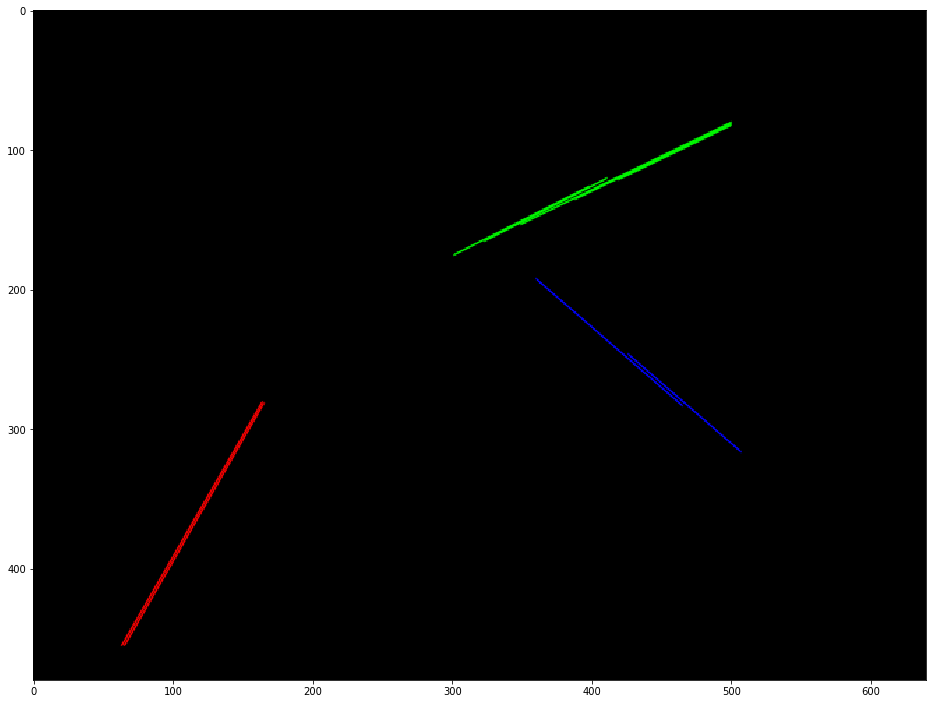

In [14]:
plt.figure(figsize=(16,19))
plt.imshow(out)

### Impressão dos segmentos encontrados por Hough

In [15]:
names = ["red", "green", "blue"]

In [16]:
for i in range(len(names)):
    print(names[i])
    for s in segs[i]:
        print(s)

red
((65, 455), (165, 281))
((63, 455), (164, 280))
green
((419, 121), (500, 82))
((349, 153), (500, 80))
((301, 175), (398, 126))
((388, 135), (500, 81))
((323, 165), (411, 120))
blue
((360, 192), (465, 283))
((426, 246), (507, 316))


Assim como no exercício de estimativa de pontos de fuga, precisamos lidar com o fato de haver mais de um segmento detectado por reta. Vamos escolher *qualquer um* de cada cor e ver como será o resultado

Usaremos o algoritmo que calcula interseção de retas dados 2 segmentos que foi fornecido na [atividade de ponto de fuga](https://github.com/Insper/robot20/blob/master/aula03/atividade_Semana03.ipynb).

In [17]:
import random

In [18]:
def find_m_h(segmento):
    a = segmento[0]
    b = segmento[1]
    m = (b[1] - a[1])/(b[0] - a[0])
    h = a[1] - m*a[0]
    return m,h

def intersect_segs(seg1, seg2):
    m1,h1 = find_m_h(seg1)
    m2,h2 = find_m_h(seg2)
    x_i = (h2 - h1)/(m1-m2)
    y_i = m1*x_i + h1
    return x_i, y_i

def intersection(lista1, lista2):
    seg1 = random.choice(lista1)
    seg2 = random.choice(lista2)
    pt = intersect_segs(seg1, seg2)
    return (int(pt[0]), int(pt[1]))

Verificando `intersect_segs`com os valores de teste fornecidos na aula 03:

In [19]:
intersect_segs([(3,2.5),(4, 0.6)],[(1,2.4),(.6,1.1)])

(1.7572815533980581, 4.861165048543689)

In [20]:
intersect_segs([(4, 0.6), (3, 2.5)],[(.6,1.1),(1,2.4)])

(1.7572815533980581, 4.861165048543689)

## Encontro entre  retas R e G

In [21]:
inter_r_b = intersection(seg_r, seg_g)

In [22]:
inter_r_b

(196, 226)

Vamos usar a função de crosshair da [aula 2 - exemplos](https://github.com/Insper/robot20/blob/master/aula02/Atividade2_Exemplos.ipynb) mas modificado para fazer cada segmento de uma cor: 

In [23]:
def crosshair(img, point, size, color1, color2):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color1,5)
    cv2.line(img,(x,y - size),(x, y + size),color2,5)    

In [24]:
crosshair(frame, inter_r_b, 10, r_color, g_color)

## Encontro entre retas G e B

In [25]:
inter_g_b = intersection(seg_g, seg_b)
crosshair(frame, inter_g_b, 10, g_color, b_color)

## Encontro entre retas B e R

In [26]:
inter_b_r = intersection(seg_b, seg_r)
crosshair(frame, inter_b_r, 10, b_color, r_color)

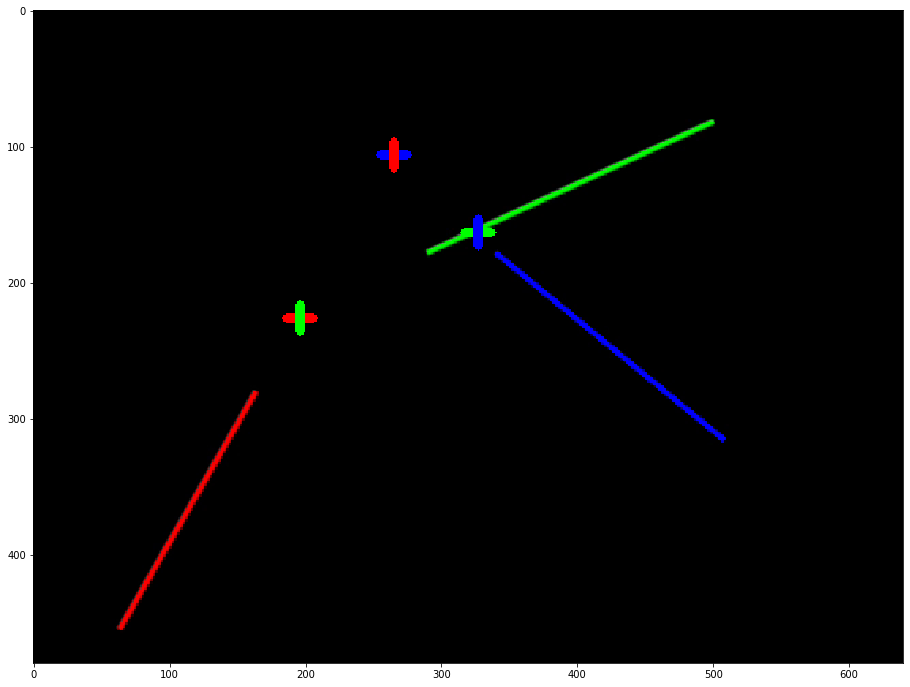

In [27]:
plt.figure(figsize=(20,12))
plt.imshow(frame)